# 6. Data Aggregation

_Frederic Hopp and Penny Sheets_

This week, we will particularly look at techniques for aggregating data and for
joining datasets. We use data on housing prices from https://data.amsterdam.nl/
.


As always, we first import some modules we need and load our data file.


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/FeLoe/data_journalism/master/content/wozwaarde.csv', delimiter=';')

## Cleaning up and recoding

When we inspect the data, we see that each "wijk" seems to be represented by a
code (a letter plus two numbers). Essentially, the code is the first word of the
"wijk" column. Let's put it into a new coloumn.

The lambda function says: Take each cell, call the value `x`, split `x` into a
list of words (we did that in the week on analyzing text), and then return the
0st element. We then put the result into a new column called `code`.


In [3]:
df.head()

,wijk,2014,2015,2016,2017,2018
0,A00 Burgwallen-Oude Zijde,263417.0,273525.0,289984.0,339548.0,400010.0
1,A01 Burgwallen-Nieuwe Zijde,267895.0,281193.0,296762.0,351214.0,391011.0
2,A02 Grachtengordel-West,490251.0,502230.0,560841.0,674610.0,755091.0
3,A03 Grachtengordel-Zuid,469946.0,478371.0,531225.0,627625.0,697576.0
4,A04 Nieuwmarkt/Lastage,295239.0,303500.0,340364.0,386716.0,438942.0


In [4]:
df['code'] = df['wijk'].map(lambda x: x.split()[0])

If we now inspect the rows closer, we can see that the "wijken" have a letter
and a two-digit numerical code, whereas some rows (e.g., row 10) contain
information on the "stadsdeel" level, signified by only the letter.

This tells us something about the data structure.

It seems problematic that both are in the same tabel, given that the "stadsdeel"
rows are essentially contain aggregated data from the "wijken". We could check
that, but it seems very reasonable to assume this, based on just looking at the
dataframe.

Probably, it's a good idea to seperate our dataframe into two different
dataframes.

We can do so by just checking the length of the value in the `code` column that
we created.


In [5]:
df

,wijk,2014,2015,2016,2017,2018,code
0,A00 Burgwallen-Oude Zijde,263417.0,273525.0,289984.0,339548.0,400010.0,A00
1,A01 Burgwallen-Nieuwe Zijde,267895.0,281193.0,296762.0,351214.0,391011.0,A01
2,A02 Grachtengordel-West,490251.0,502230.0,560841.0,674610.0,755091.0,A02
3,A03 Grachtengordel-Zuid,469946.0,478371.0,531225.0,627625.0,697576.0,A03
4,A04 Nieuwmarkt/Lastage,295239.0,303500.0,340364.0,386716.0,438942.0,A04
...,...,...,...,...,...,...,...
101,T95 Nellestein,139614.0,137902.0,134903.0,140373.0,170441.0,T95
102,T96 Holendrecht/Reigersbos,146686.0,143554.0,147751.0,153254.0,181189.0,T96
103,T97 Gein,163287.0,161513.0,165247.0,176573.0,199542.0,T97
104,T98 Driemond,227969.0,224884.0,234149.0,251670.0,267328.0,T98


In [6]:
# select only the "stadsdelen" and put them into a new dataframe
stadsdelen = df[df['code'].map(lambda x: len(x)==1)]
stadsdelen['wijk'] = stadsdelen['wijk'].map(lambda x: x[2:])

/var/folders/l0/0m8rr1_910j7vgvw7jz29qgc0000gn/T/ipykernel_9477/3819408376.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stadsdelen['wijk'] = stadsdelen['wijk'].map(lambda x: x[2:])


Let's read the information which letter is associated with which "stadsdeel"
into a dictionary, that we can later use for recoding.


In [7]:
stadsdeelcodes = {}
for k, v in stadsdelen[['wijk','code']].to_dict(orient='index').items():
    stadsdeelcodes.update({v['code']: v['wijk']})

In [8]:
stadsdeelcodes

{'A': 'Centrum',
 'B': 'Westpoort',
 'E': 'West',
 'F': 'Nieuw-West',
 'K': 'Zuid',
 'M': 'Oost',
 'N': 'Noord',
 'T': 'Zuidoost'}

In [9]:
# put all "wijken" (which have a code that is longer than 1) into a new dataframe, 
# and remove their code (the first 4 characters) from their name
wijken = df[df['code'].map(lambda x: len(x)>1)]
wijken['wijk'] = wijken['wijk'].map(lambda x: x[4:])

/var/folders/l0/0m8rr1_910j7vgvw7jz29qgc0000gn/T/ipykernel_9477/728820632.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wijken['wijk'] = wijken['wijk'].map(lambda x: x[4:])


In [10]:
wijken

,wijk,2014,2015,2016,2017,2018,code
0,Burgwallen-Oude Zijde,263417.0,273525.0,289984.0,339548.0,400010.0,A00
1,Burgwallen-Nieuwe Zijde,267895.0,281193.0,296762.0,351214.0,391011.0,A01
2,Grachtengordel-West,490251.0,502230.0,560841.0,674610.0,755091.0,A02
3,Grachtengordel-Zuid,469946.0,478371.0,531225.0,627625.0,697576.0,A03
4,Nieuwmarkt/Lastage,295239.0,303500.0,340364.0,386716.0,438942.0,A04
...,...,...,...,...,...,...,...
100,"Bijlmer-Oost (E,G,K)",148048.0,143943.0,148343.0,156291.0,182291.0,T94
101,Nellestein,139614.0,137902.0,134903.0,140373.0,170441.0,T95
102,Holendrecht/Reigersbos,146686.0,143554.0,147751.0,153254.0,181189.0,T96
103,Gein,163287.0,161513.0,165247.0,176573.0,199542.0,T97


We can now use the dictionry that we made above to automatically code in which
stadsdeel a wijk is located (by looking up the first character (i.e., the
letter) of their code in the dictionary `stadsdeelcodes` and putting the
corresponding value in a new column, `stadsdeel`.


In [11]:
wijken['stadsdeel'] = wijken['code'].map(lambda x: stadsdeelcodes[x[:1]])

/var/folders/l0/0m8rr1_910j7vgvw7jz29qgc0000gn/T/ipykernel_9477/1930106365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wijken['stadsdeel'] = wijken['code'].map(lambda x: stadsdeelcodes[x[:1]])


In [12]:
wijken.columns

Index(['wijk', '2014', '2015', '2016', '2017', '2018', 'code', 'stadsdeel'], dtype='object')

In [13]:
wijken

,wijk,2014,2015,2016,2017,2018,code,stadsdeel
0,Burgwallen-Oude Zijde,263417.0,273525.0,289984.0,339548.0,400010.0,A00,Centrum
1,Burgwallen-Nieuwe Zijde,267895.0,281193.0,296762.0,351214.0,391011.0,A01,Centrum
2,Grachtengordel-West,490251.0,502230.0,560841.0,674610.0,755091.0,A02,Centrum
3,Grachtengordel-Zuid,469946.0,478371.0,531225.0,627625.0,697576.0,A03,Centrum
4,Nieuwmarkt/Lastage,295239.0,303500.0,340364.0,386716.0,438942.0,A04,Centrum
...,...,...,...,...,...,...,...,...
100,"Bijlmer-Oost (E,G,K)",148048.0,143943.0,148343.0,156291.0,182291.0,T94,Zuidoost
101,Nellestein,139614.0,137902.0,134903.0,140373.0,170441.0,T95,Zuidoost
102,Holendrecht/Reigersbos,146686.0,143554.0,147751.0,153254.0,181189.0,T96,Zuidoost
103,Gein,163287.0,161513.0,165247.0,176573.0,199542.0,T97,Zuidoost


## From wide to long

If you look at the dataframe `wijken`, you will see that it is structured in a
so-called _wide_ format. That means that you have multiple measurements of the
same thing (the house vlaues) in different columns, depending on in which year
it was measured.

In other words: there is no column (variable) `year` that would tell you when a
measurement has taken place, but this information is essentially encoded in the
column names.

For many analyses, this is quite unfortunate. After all, we cannout do sth like
`.groupby('year')` in a dataset that is formatted this way.

We will therefore transform it into a more tidy format, a _long_ format. The
`.melt()` method allows us to do so. We need to specify which variables stay the
same and identify the cases (`id_vars`), which columns contain the values
(`value_vars`), and how the two new variables to store the old column names and
the cell entries in (`var_name` and `value_name`).


In [14]:
wijken_long = wijken.melt(id_vars=['wijk','stadsdeel'], 
                          value_vars=['2014', '2015', '2016', '2017', '2018'],
                          value_name='woz-waarde',
                          var_name = 'year')

In [15]:
wijken_long

,wijk,stadsdeel,year,woz-waarde
0,Burgwallen-Oude Zijde,Centrum,2014,263417.0
1,Burgwallen-Nieuwe Zijde,Centrum,2014,267895.0
2,Grachtengordel-West,Centrum,2014,490251.0
3,Grachtengordel-Zuid,Centrum,2014,469946.0
4,Nieuwmarkt/Lastage,Centrum,2014,295239.0
...,...,...,...,...
485,"Bijlmer-Oost (E,G,K)",Zuidoost,2018,182291.0
486,Nellestein,Zuidoost,2018,170441.0
487,Holendrecht/Reigersbos,Zuidoost,2018,181189.0
488,Gein,Zuidoost,2018,199542.0


Let's save it for future usage (and for some other notebooks in the next weeks.


In [16]:
wijken_long.to_csv('wijken_long.csv')

## Some analysis with `.groupby()` and `.agg()`

Have a look at the slides for more info on `.groupby()` and `.agg()`.


In [17]:
#wijken_long.index = pd.DatetimeIndex(wijken_long.year.map(lambda x: "1-1-{}".format(x)))

In [18]:
wijken_long.head()

,wijk,stadsdeel,year,woz-waarde
0,Burgwallen-Oude Zijde,Centrum,2014,263417.0
1,Burgwallen-Nieuwe Zijde,Centrum,2014,267895.0
2,Grachtengordel-West,Centrum,2014,490251.0
3,Grachtengordel-Zuid,Centrum,2014,469946.0
4,Nieuwmarkt/Lastage,Centrum,2014,295239.0


<Axes: xlabel='year'>

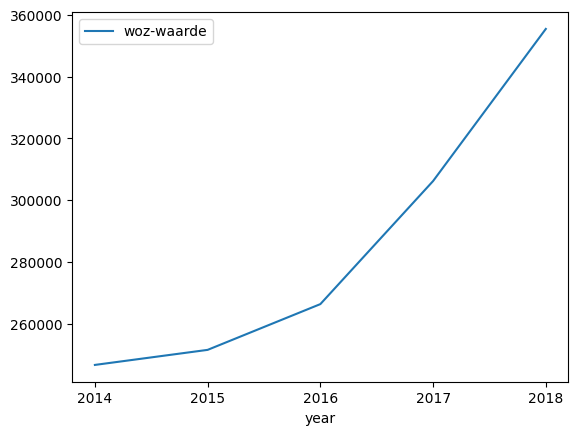

In [19]:
wijken_long.groupby('year').agg("mean", numeric_only=True).plot(xticks=[0,1,2,3,4])

<Axes: xlabel='year'>

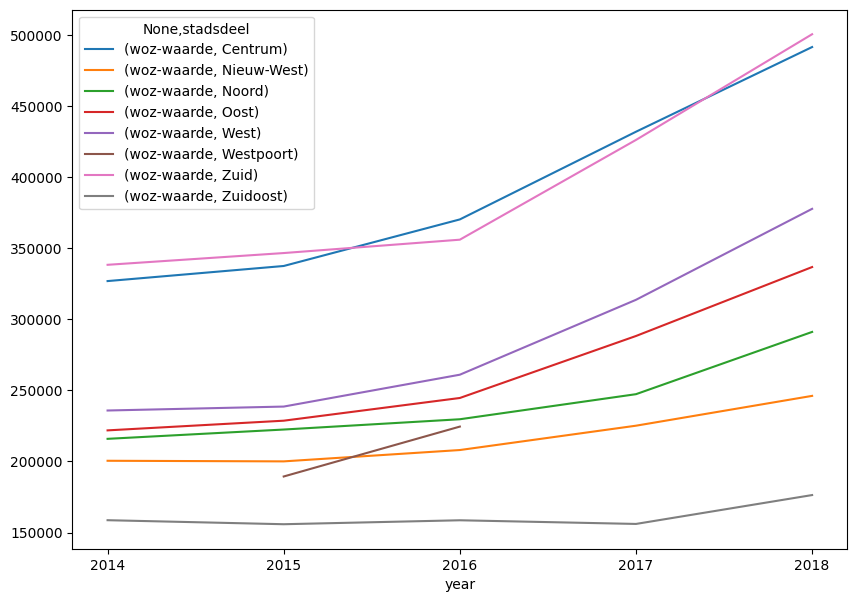

In [20]:
wijken_long.groupby(['year','stadsdeel']).agg("mean", numeric_only = True).unstack().plot(
    figsize=[10,7], xticks=range(5))

As also explained on the slides, the `.unstack()` part is needed to flatten the
hierarchical index that grouping by _two_ variables creates. If we want to read
the table, we don't need to unstack it, but we cannot directly plot the stacked
table. Try it with and without!


In [21]:
wijken_long.groupby(['year','stadsdeel']).agg("mean", numeric_only=True).unstack()

woz-waarde                                                         \
stadsdeel    Centrum     Nieuw-West          Noord           Oost      West   
year                                                                          
2014        326814.1  200453.500000  215879.500000  221828.142857  235801.0   
2015        337425.5  200028.000000  222417.200000  228636.000000  238568.8   
2016        370176.0  208002.428571  229650.466667  244608.428571  260979.4   
2017        431837.9  225116.571429  247279.400000  288196.357143  313645.2   
2018        491394.7  246089.000000  291062.866667  336683.500000  377618.1   

                                                 
stadsdeel Westpoort         Zuid       Zuidoost  
year                                             
2014            NaN  338256.8000  158662.833333  
2015       189402.0  346524.6250  155835.000000  
2016       224491.0  355919.6250  158611.000000  
2017            NaN  426073.5000  156034.571429  
2018            NaN  500404.5625  176345.571429

In [22]:
oost = wijken_long[wijken_long['stadsdeel']=='Oost']

<Axes: xlabel='year'>

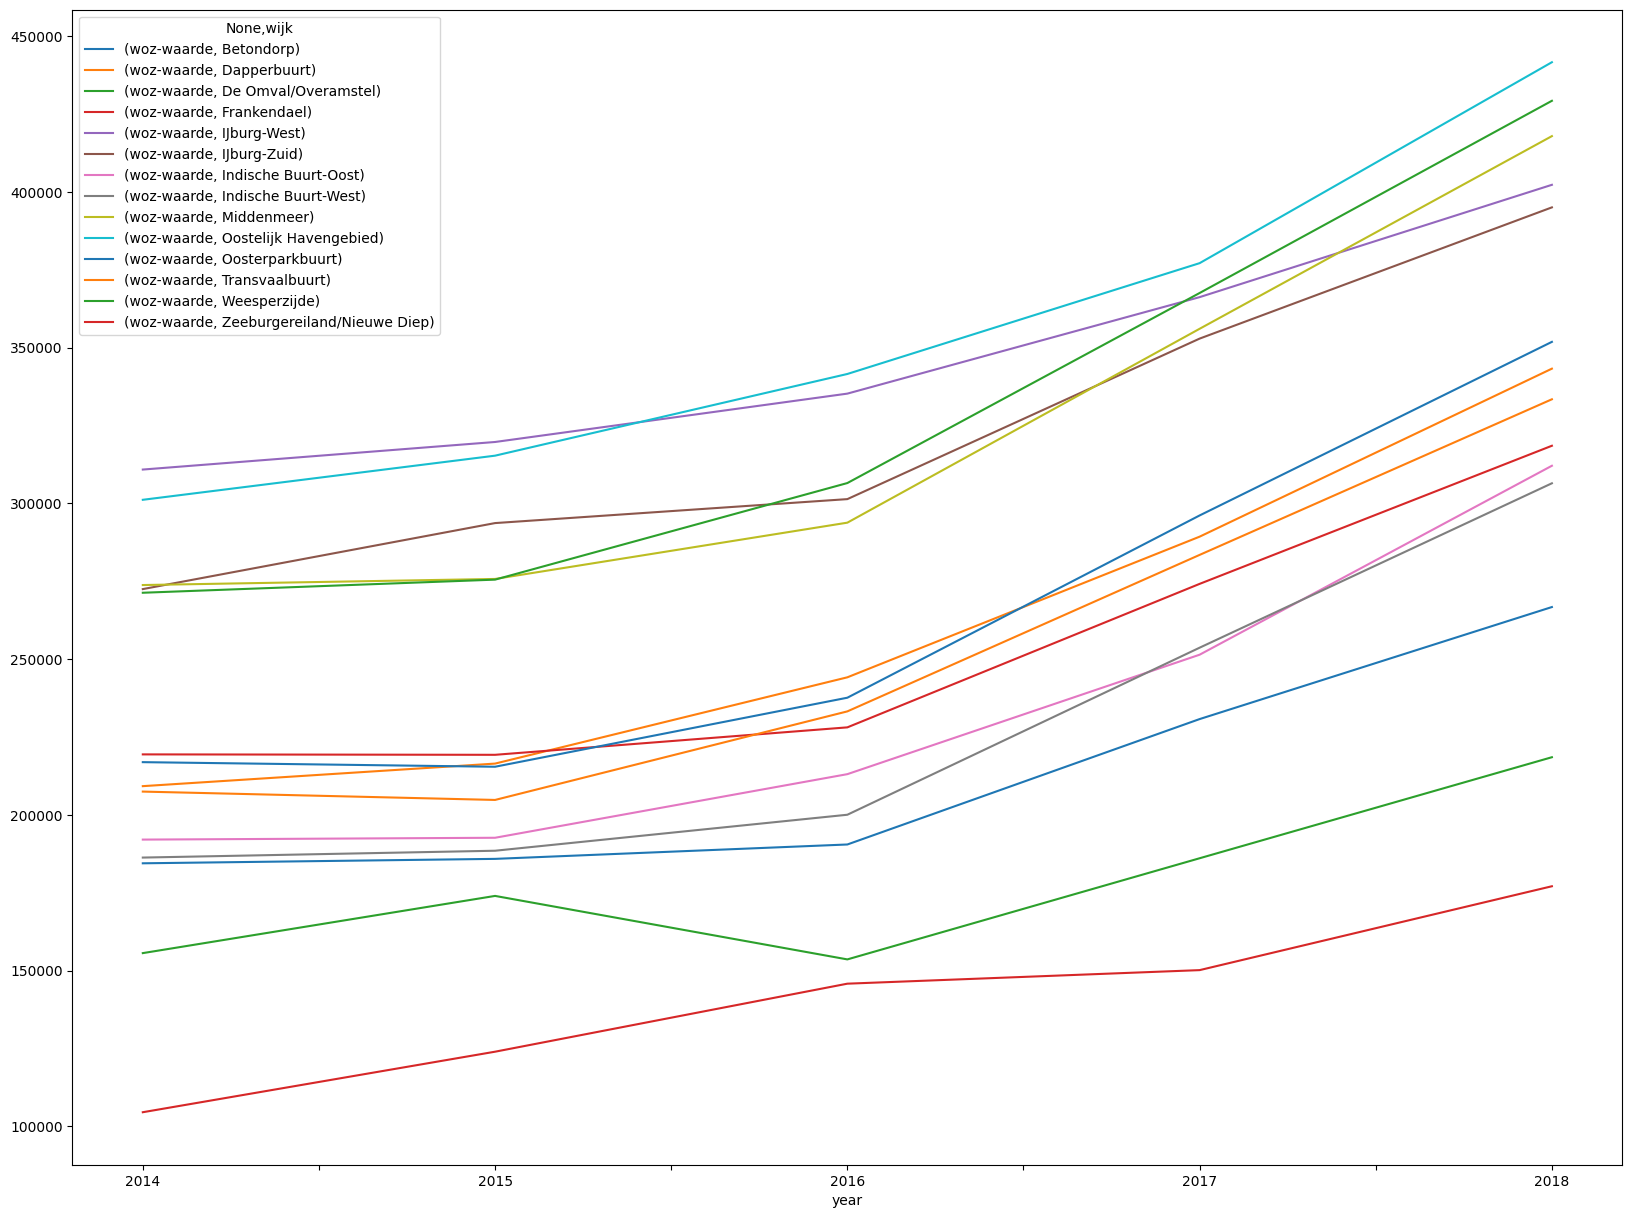

In [23]:
oost.groupby(['year','wijk']).agg("mean", numeric_only=True).unstack().plot(figsize=[20,15])

In [24]:
oost[oost.wijk=='Dapperbuurt']

,wijk,stadsdeel,year,woz-waarde
64,Dapperbuurt,Oost,2014,209223.0
162,Dapperbuurt,Oost,2015,216466.0
260,Dapperbuurt,Oost,2016,244155.0
358,Dapperbuurt,Oost,2017,289299.0
456,Dapperbuurt,Oost,2018,343221.0


In [25]:
oost[oost.wijk.str.startswith('Indisch')]

,wijk,stadsdeel,year,woz-waarde
66,Indische Buurt-West,Oost,2014,186301.0
67,Indische Buurt-Oost,Oost,2014,192071.0
164,Indische Buurt-West,Oost,2015,188495.0
165,Indische Buurt-Oost,Oost,2015,192657.0
262,Indische Buurt-West,Oost,2016,200048.0
263,Indische Buurt-Oost,Oost,2016,213074.0
360,Indische Buurt-West,Oost,2017,253664.0
361,Indische Buurt-Oost,Oost,2017,251413.0
458,Indische Buurt-West,Oost,2018,306433.0
459,Indische Buurt-Oost,Oost,2018,312058.0


In [26]:
wijken_long.groupby(['year','stadsdeel'])['woz-waarde'].agg([min,max])

/var/folders/l0/0m8rr1_910j7vgvw7jz29qgc0000gn/T/ipykernel_9477/992137526.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  wijken_long.groupby(['year','stadsdeel'])['woz-waarde'].agg([min,max])
/var/folders/l0/0m8rr1_910j7vgvw7jz29qgc0000gn/T/ipykernel_9477/992137526.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  wijken_long.groupby(['year','stadsdeel'])['woz-waarde'].agg([min,max])


min        max
year stadsdeel                      
2014 Centrum     253990.0   490251.0
     Nieuw-West  141387.0   374106.0
     Noord       150516.0   428832.0
     Oost        104568.0   310839.0
     West        164263.0   564043.0
     Westpoort        NaN        NaN
     Zuid        225636.0   664230.0
     Zuidoost    126373.0   227969.0
2015 Centrum     256421.0   502230.0
     Nieuw-West  139528.0   368054.0
     Noord       150413.0   437326.0
     Oost        123993.0   319688.0
     West        167242.0   595181.0
     Westpoort   189402.0   189402.0
     Zuid        228441.0   664514.0
     Zuidoost    123214.0   224884.0
2016 Centrum     276481.0   560841.0
     Nieuw-West  139872.0   388082.0
     Noord       154881.0   442483.0
     Oost        145825.0   341516.0
     West        182309.0   630566.0
     Westpoort   224491.0   224491.0
     Zuid        241511.0   677933.0
     Zuidoost    121273.0   234149.0
2017 Centrum     316261.0   674610.0
     Nieuw-West  157018.0   430190.0
     Noord       168528.0   480514.0
     Oost        150175.0   377085.0
     West        219773.0   754544.0
     Westpoort        NaN        NaN
     Zuid        266394.0   839342.0
     Zuidoost     78137.0   251670.0
2018 Centrum     381774.0   755091.0
     Nieuw-West   93104.0   483447.0
     Noord       196081.0   565361.0
     Oost        177096.0   441577.0
     West        269738.0   844347.0
     Westpoort        NaN        NaN
     Zuid        330366.0  1003743.0
     Zuidoost     81201.0   267328.0

Difference between most expensive and least expensive buurt within stadsdeel


<Axes: xlabel='year'>

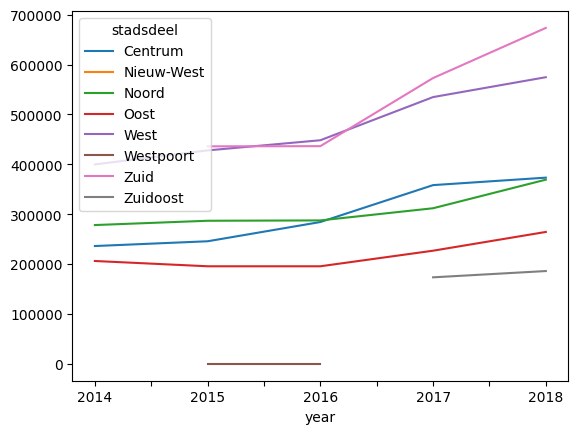

In [27]:
print('Difference between most expensive and least expensive buurt within stadsdeel')
wijken_long.groupby(['year','stadsdeel'])['woz-waarde'].agg(lambda x: max(x)-min(x)).unstack().plot()

Difference between most expensive and least expensive buurt within stadsdeel


<Axes: xlabel='year'>

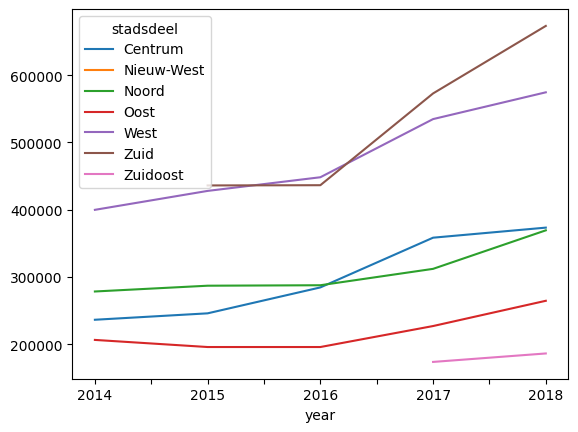

In [28]:
print('Difference between most expensive and least expensive buurt within stadsdeel')
wijken_long[wijken_long['stadsdeel']!= 'Westpoort'].groupby(
    ['year','stadsdeel'])['woz-waarde'].agg(lambda x: max(x)-min(x)).unstack().plot()

We see that differences within stadsdeel rise.


# Now it's your turn.

Think of other aggregations, either with this or with other datasets!
